In [1]:
# imports
import os, sys
import numpy as np
import tensorflow as tf
import voxelmorph as vxm
import neurite as ne
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'
import h5py
import matplotlib.pyplot as plt

import utilitary as util

In [2]:
hf = h5py.File("dataset2.h5", "r")

In [3]:
keys = hf.keys()
use_key = util.remove_empty_key(hf, keys)
x,y,z = hf.get('0')['frame'][0].shape
       
nb_entries = len(use_key) 
list_keys = list(use_key)

In [133]:
r_MIP = util.red_MIP(hf, list_keys[:50], axis = 2)

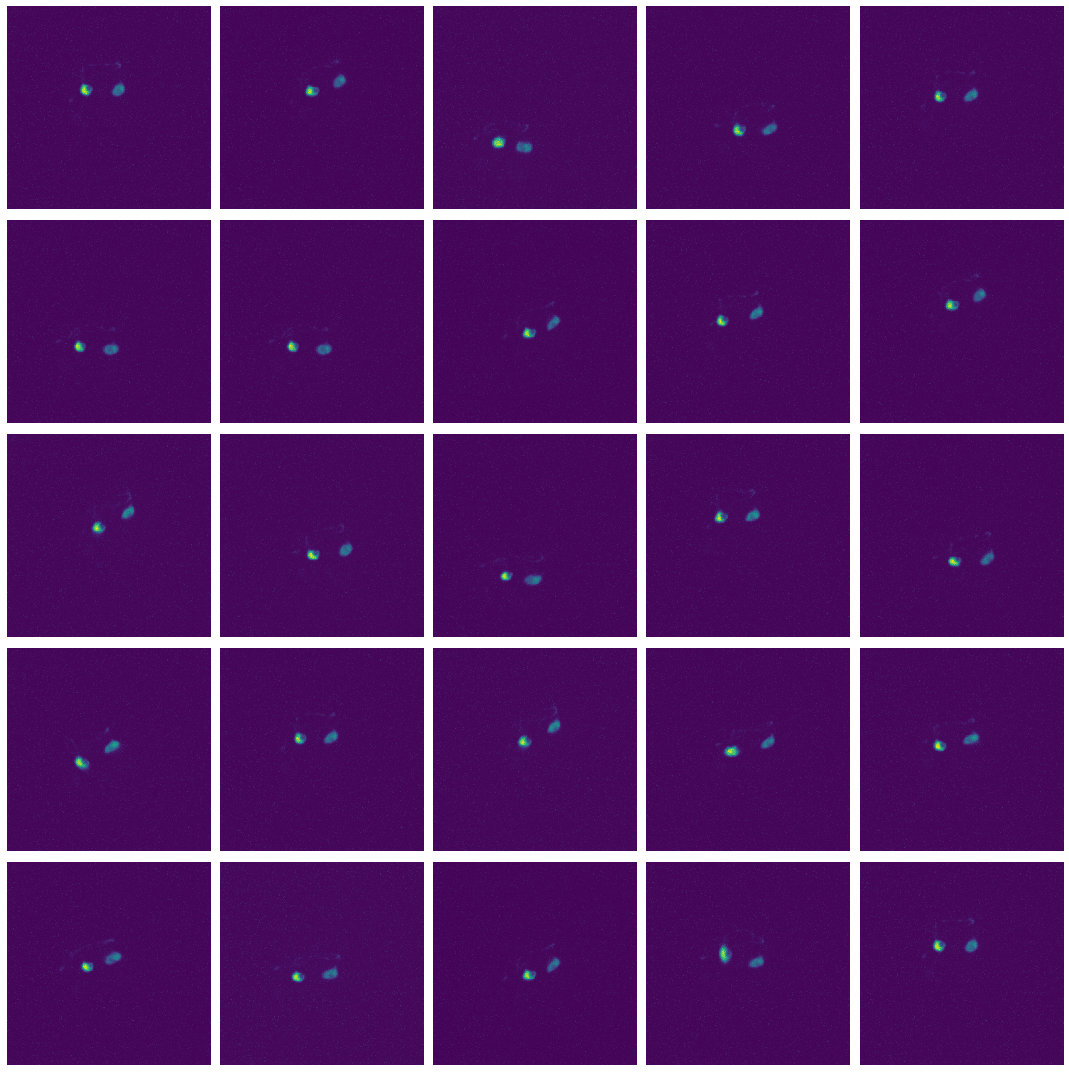

In [5]:
# Plot true RGB MIP images
i=5
j=5
idx= np.random.randint(0,50,i*j)
plots = [r_MIP[i] for i in idx]
ne.plot.slices(plots, do_colorbars=True, grid = [i,j]);

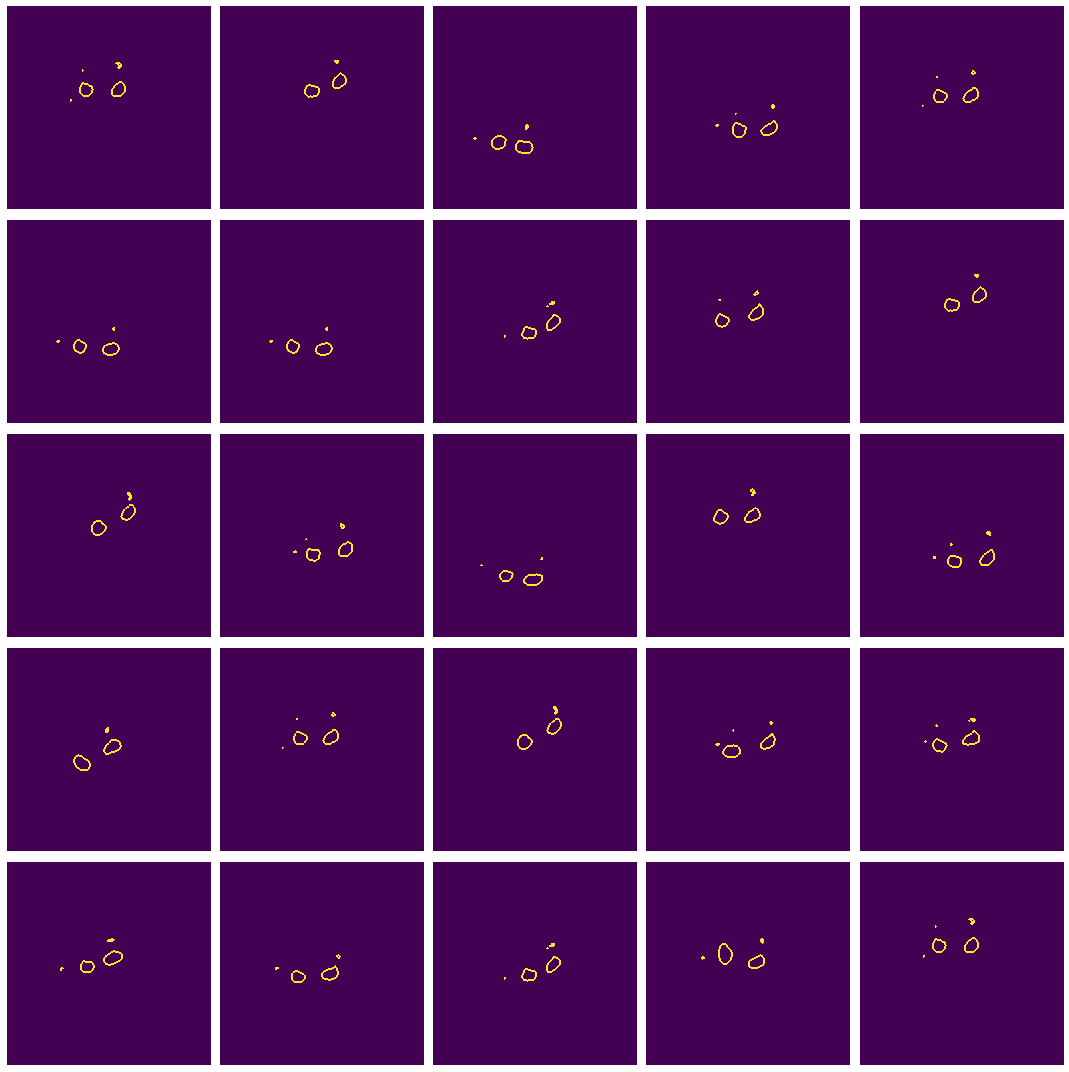

In [6]:
MIP, _ = util.find_contour(r_MIP,0.8,blur=5)

# Plot true RGB MIP images
i=5
j=5
plots = [MIP[i] for i in idx]
ne.plot.slices(plots, do_colorbars=True, grid = [i,j]);

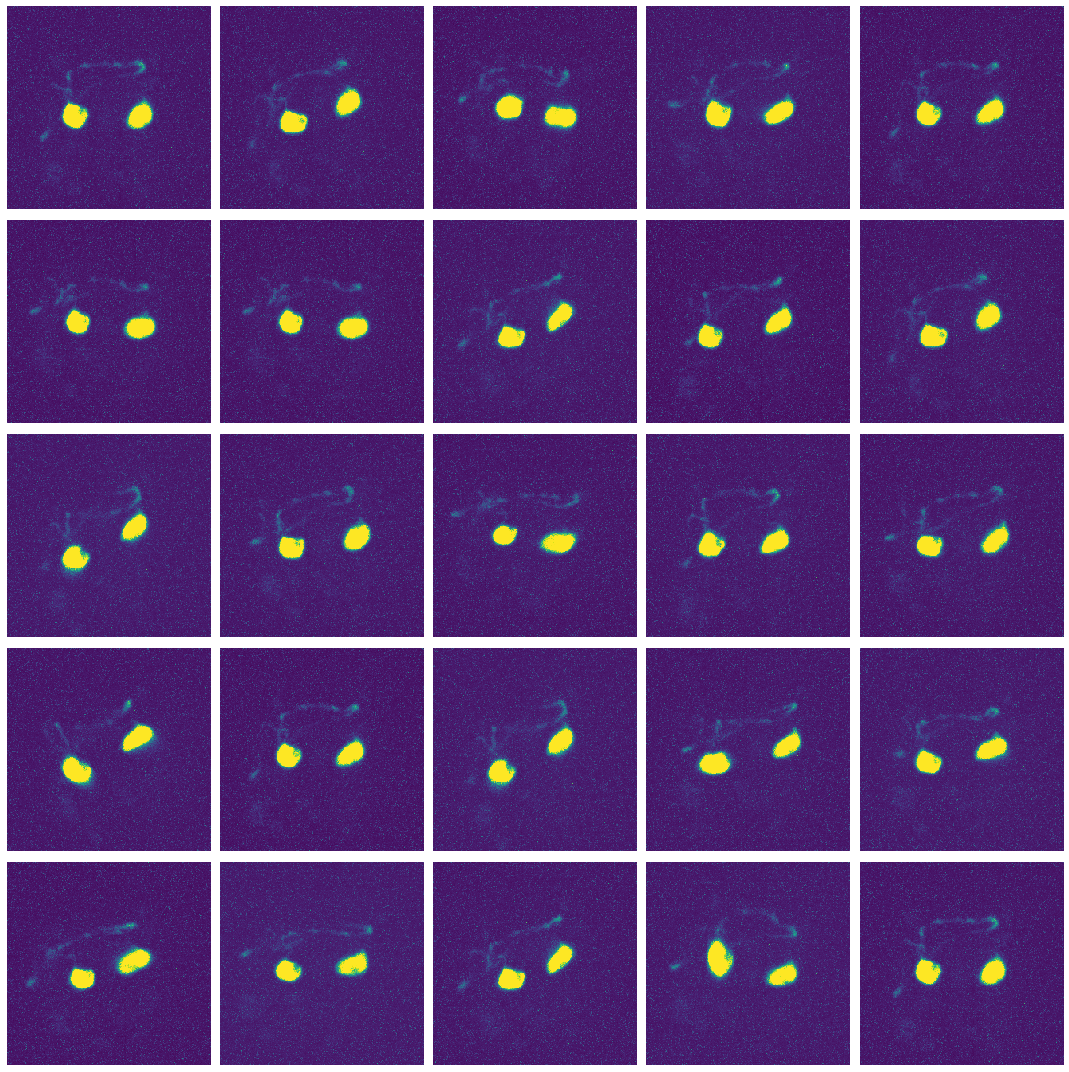

In [7]:
plots = [util.crop_ctr_mass(r_MIP[i]) for i in idx]
ne.plot.slices(plots, do_colorbars=True, grid = [i,j]);

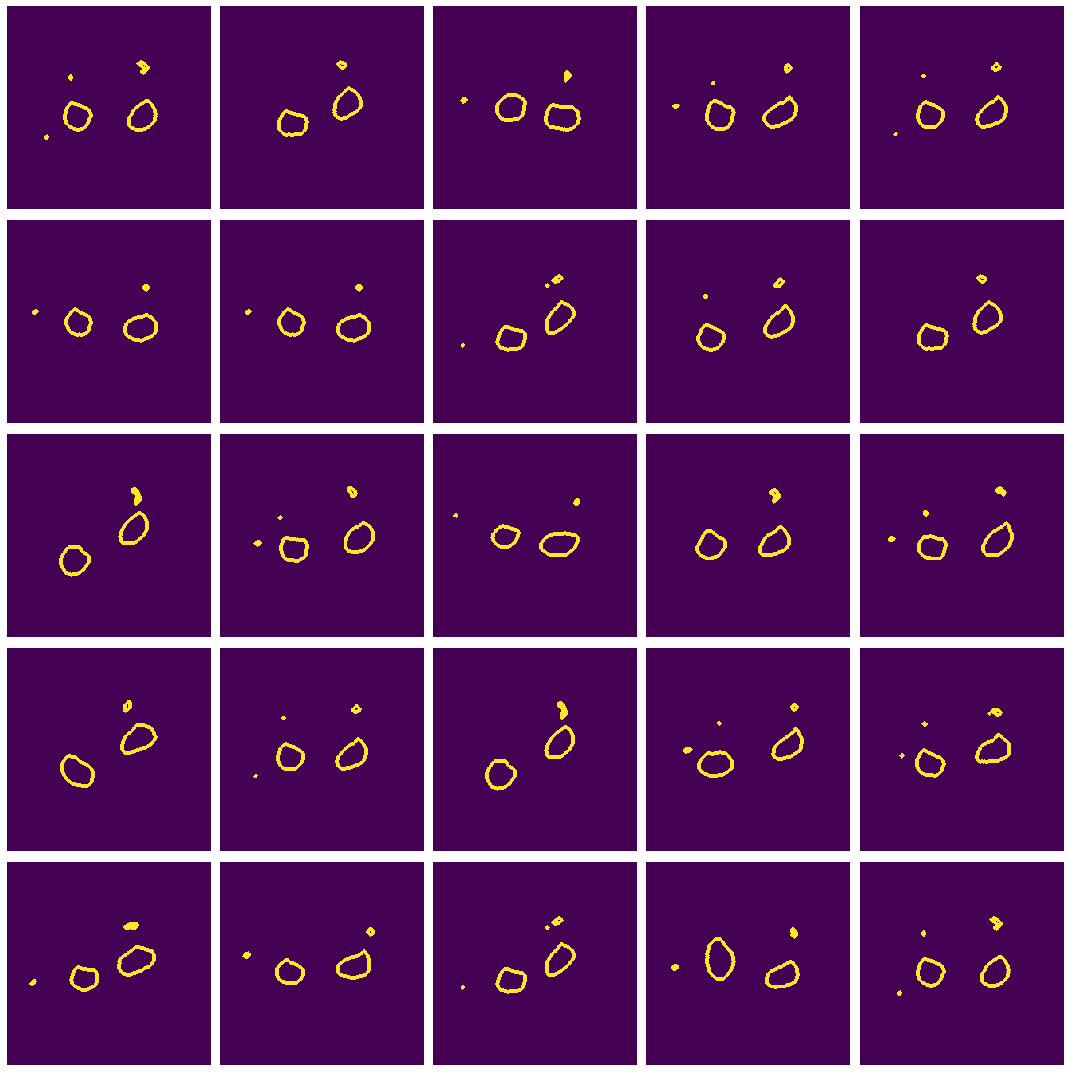

In [8]:
plots = [util.crop_ctr_mass(MIP[i]) for i in idx]
ne.plot.slices(plots, do_colorbars=True, grid = [i,j]);

In [118]:
import cv2
def split_nucleus(images, mod=1.1, clamp_val=300, blur=5):
    """split image and into few parts, one neclues in each"""
    
    if len(images.shape) == 2:
        images = images[np.newaxis,...]
    all_contours = np.empty(images.shape)
    all_ret = np.empty(images.shape[0])

    for i, im in enumerate(images):

        # Get the original values of the image back
        if np.max(im) < 255 :
            im2 = im * 255
        # The image is already in its original form
        else :
            im2 = im
        # Clamp the values of im2 from [0, max_val], because some intensity
        # values are > 255
        max_val = clamp_val
        im2[im2 > max_val] = max_val
        # Change the type in uint8 for drawContours
        im2 = (im2/max_val*255).astype(np.uint8)

        # Blur the image to remove noise
        # You can also use : cv2.GaussianBlur(im,(3,3),0)
        im2 = cv2.medianBlur(im2,blur)

        # Perform a binary threshold + OTSU
        all_ret[i], th1 = cv2.threshold(im2, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        # Use a threshold = optimal threshold * 1.1 = all_ret[i]*1.1
        # You can also use cv2.adaptiveThreshold(im2,im2.max(),cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        # cv2.THRESH_BINARY,3,2)
        _, th1 = cv2.threshold(im2, all_ret[i]*mod, 255, cv2.THRESH_BINARY)

        # Find contours
        contours, hierarchy = cv2.findContours(th1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
        
        big_contour = []
        max = 0
        for i in contours:
            area = cv2.contourArea(i)  # --- find the contour having biggest area ---
            if (area > 600):
                max = area
                big_contour.append(i)

        pos_neurons = []
        # draw rectangles around contours
        for contour in big_contour:
            (x, y, w, h) = cv2.boundingRect(contour)
            h += 10
            w += 10
            x -= 5
            y -= 5
            cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 2)

            pos_neurons.append([x,y,w,h])
        ne.plot.slices(im2, do_colorbars=True, grid = [1,1]);
        return pos_neurons

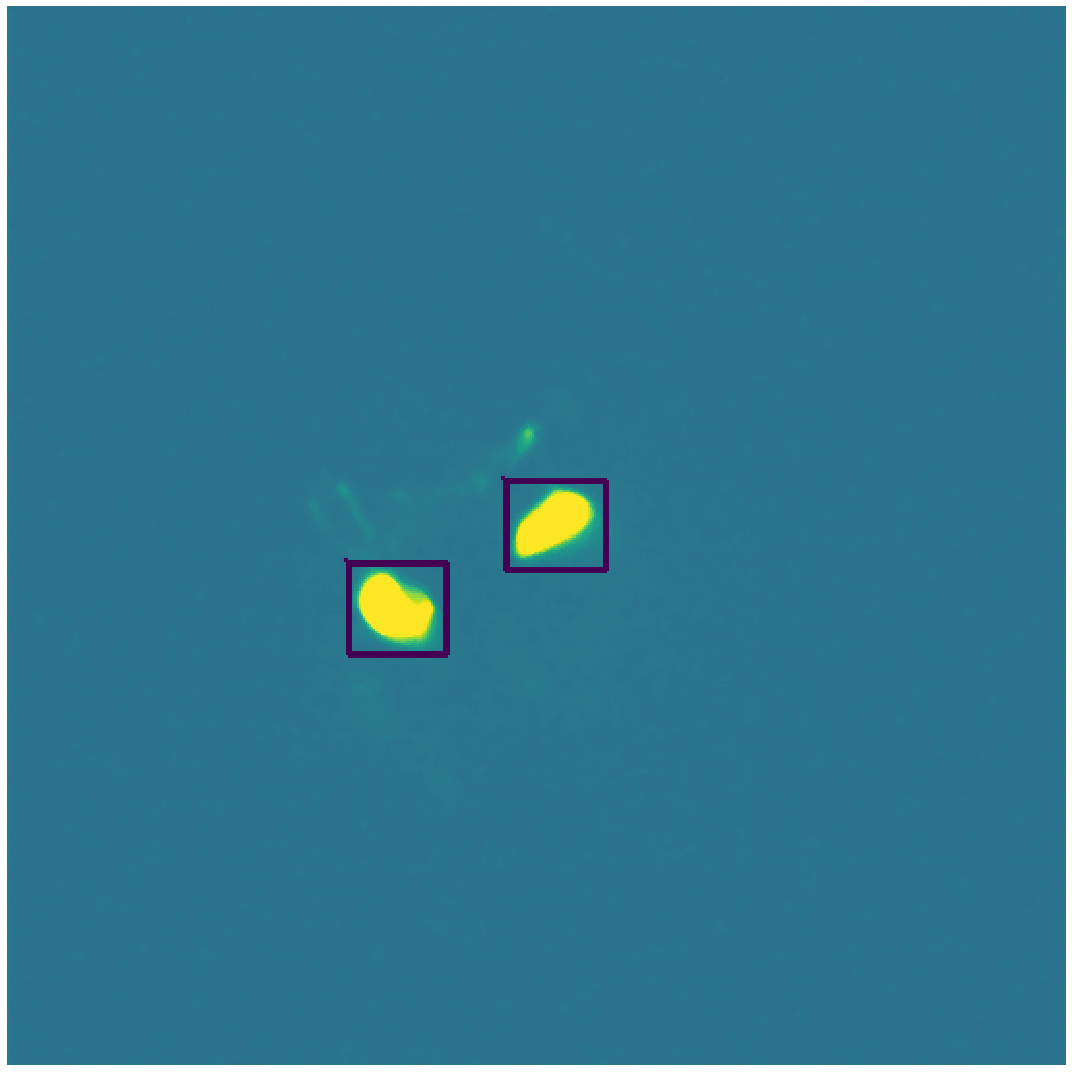

In [119]:
pos_rect = split_nucleus(r_MIP[43])

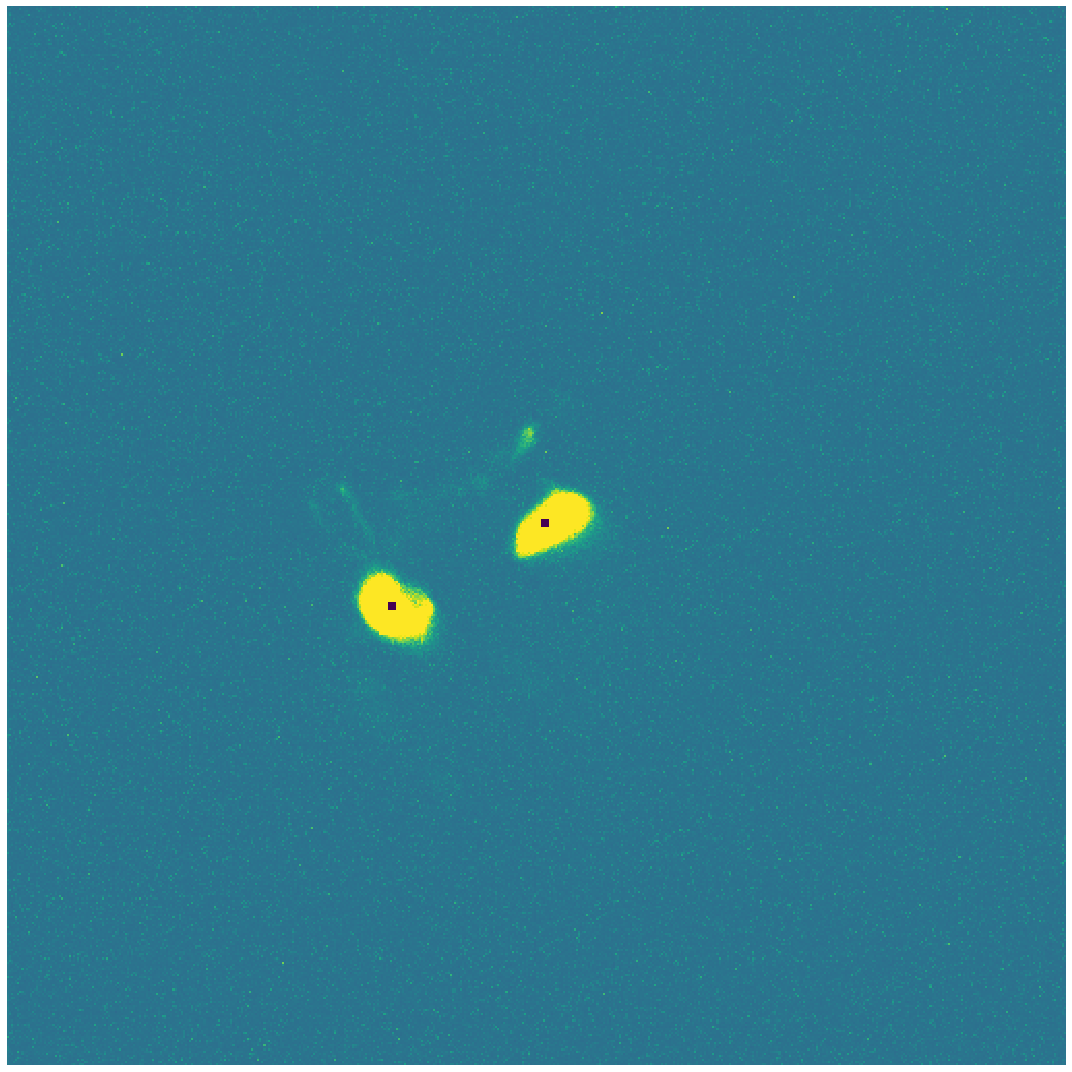

In [135]:
pos_rect
bis = r_MIP[43]
img_ctr, _ = util.find_contour(bis,0.8,blur=5)
img_ctr = img_ctr.reshape(bis.shape)
ctr_mass_list = []
for i in pos_rect:
    y, x, w, h = i
    
    tmp_img = np.zeros(bis.shape)
    tmp_img[x:x+w,y:y+h] = img_ctr[x:x+w,y:y+h]
    (x, y) = ndimage.center_of_mass(tmp_img)
    (x,y) = (int(x),int(y))
    ctr_mass_list.append((x,y))
    coord = [(x-i,y-j) for i in range(0,4) for j in range(0,4)]
    for pos in coord:
        bis[pos] = 1
ne.plot.slices(bis, do_colorbars=True, grid = [1,1]);

In [164]:
origin

array([261,   0])

In [165]:
origin = np.array([0,max(ctr_mass_list[0][1],ctr_mass_list[1][1])])
ba = ctr_mass_list[0] - origin
bc = ctr_mass_list[1] - origin
cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba)*np.linalg.norm(bc))
angle = np.degrees(np.arccos(cosine_angle))
angle

14.267646811973224

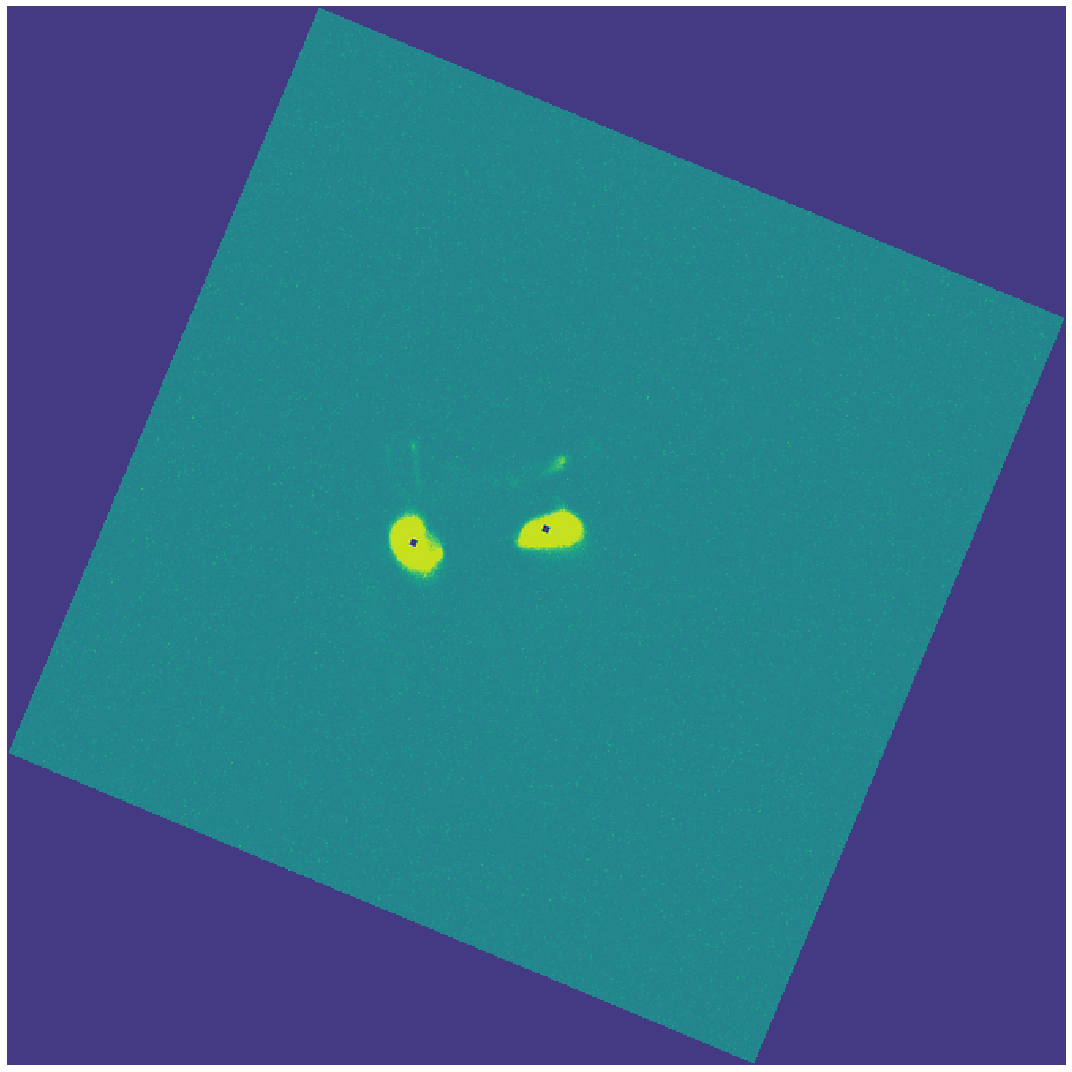

In [167]:
origin = np.array([max(ctr_mass_list[0][1],ctr_mass_list[1][1]),0])
ba = ctr_mass_list[0] - origin
bc = ctr_mass_list[1] - origin

cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba)*np.linalg.norm(bc))

angle = np.degrees(np.arccos(cosine_angle))*2
theta = (angle/180.) * np.pi

rotMatrix = np.array([[np.cos(theta), -np.sin(theta)], 
                      [np.sin(theta),  np.cos(theta)]])

#img_rot = np.dot(rotMatrix,bis)

img_rot = ndimage.rotate(bis,-angle)

ne.plot.slices(img_rot, do_colorbars=True, grid = [1,1]);

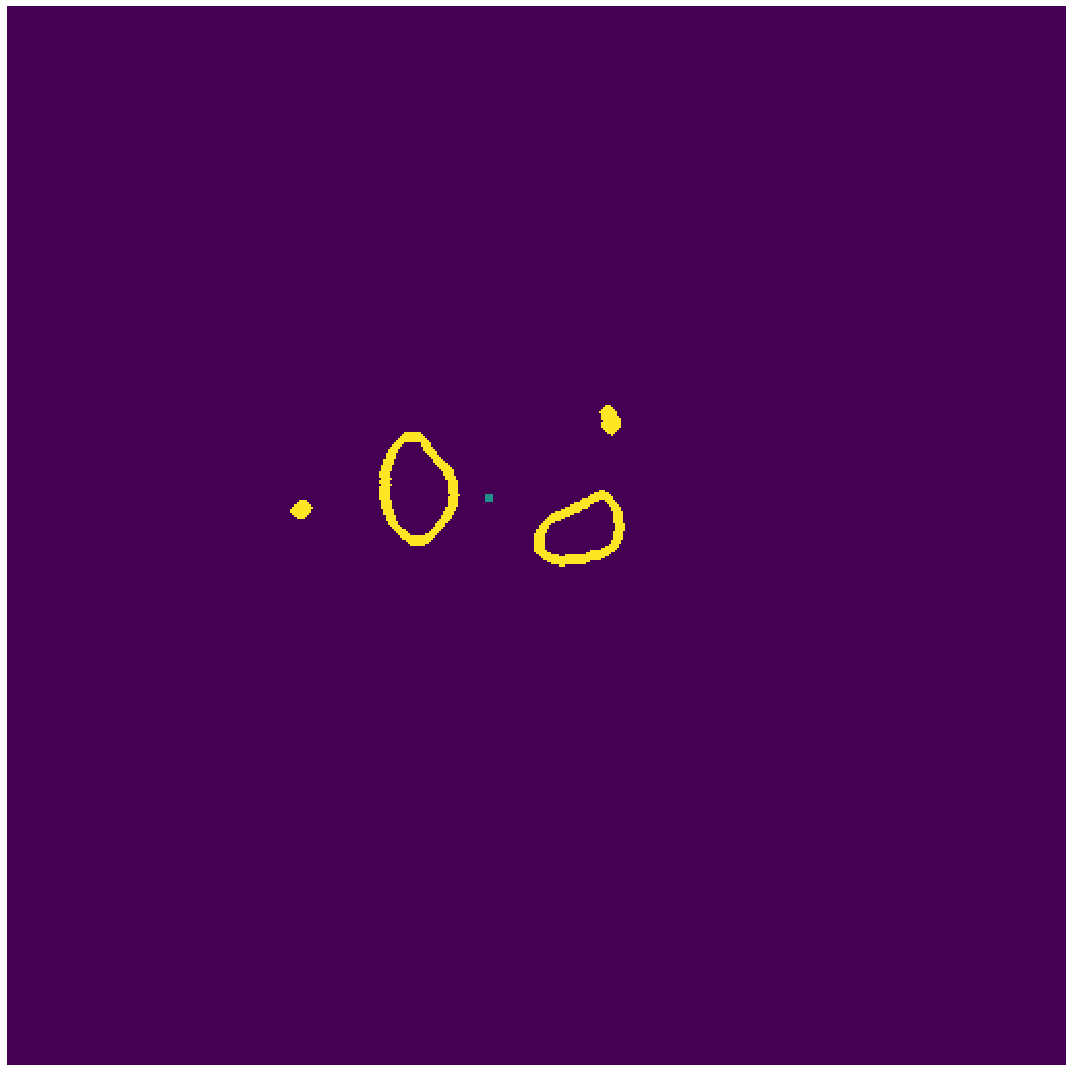

In [98]:
from scipy import ndimage
#vizualize the center of mass
idx = np.random.randint(0,50)

(x, y) = ndimage.center_of_mass(MIP[idx])
x, y = int(x), int(y)
bis = MIP[idx]
coord = [(x-i,y-j) for i in range(0,4) for j in range(0,4)]
for pos in coord:
    bis[pos] = 0.5
ne.plot.slices(bis, do_colorbars=True, grid = [1,1]);

In [10]:
#
# Split train-validation set
# 80% train - 20% validation
ratio = 0.8
keys_random = np.random.permutation(nb_entries)
keys_train = keys_random[:int(nb_entries * ratio)]
keys_test  = keys_random[int(nb_entries * ratio):]


#train on contours
#projection on z plan
r_MIP = util.red_MIP(hf, list_keys, axis = 2)

#find the contour
contours, all_ret = util.find_contour(r_MIP)

In [11]:
#cropping center of mass
#slices_train = np.array([util.crop_ctr_mass(r_MIP[i],200) for i in keys_train])
#slices_test  = np.array([util.crop_ctr_mass(r_MIP[i],200) for i in keys_test])
slices_train = np.array([util.crop_ctr_mass(contours[i],128) for i in keys_train])
slices_test  = np.array([util.crop_ctr_mass(contours[i],128) for i in keys_test])

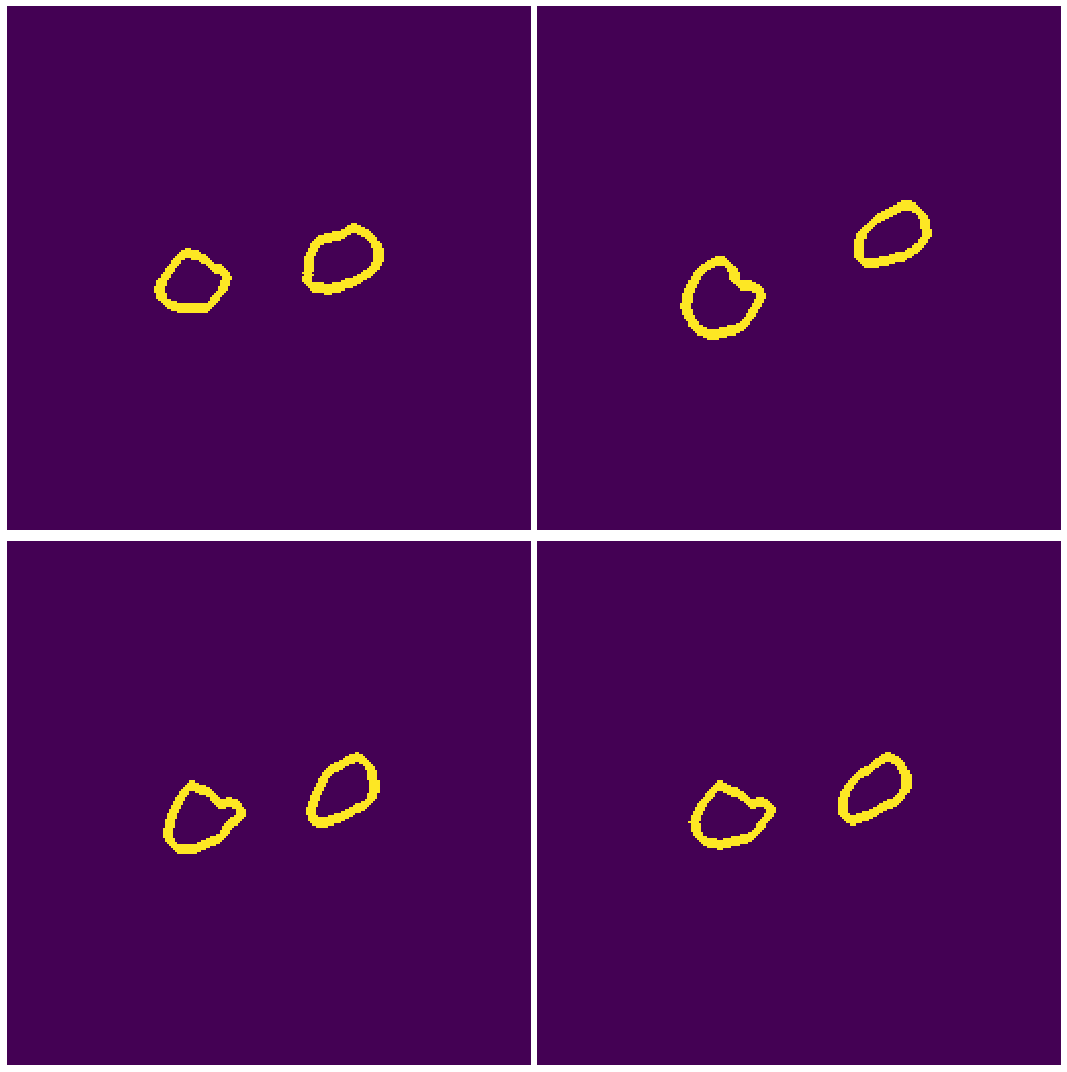

(457, 256, 256)


In [12]:
plots = [slices_train[i] for i in [7,2,5,98]]
ne.plot.slices(plots, do_colorbars=True, grid = [2,2]);

print(slices_train.shape)

Epoch 1/10
100/100 [==============================] - 488s 5s/step - loss: 0.0174 - vxm_dense_transformer_loss: 0.0174 - vxm_dense_flow_loss: 4.5568e-04
Epoch 2/10
100/100 [==============================] - 806s 8s/step - loss: 0.0106 - vxm_dense_transformer_loss: 0.0106 - vxm_dense_flow_loss: 0.0561
Epoch 3/10
100/100 [==============================] - 486s 5s/step - loss: 0.0069 - vxm_dense_transformer_loss: 0.0069 - vxm_dense_flow_loss: 0.1097
Epoch 4/10
100/100 [==============================] - 466s 5s/step - loss: 0.0054 - vxm_dense_transformer_loss: 0.0054 - vxm_dense_flow_loss: 0.1542
Epoch 5/10
100/100 [==============================] - 464s 5s/step - loss: 0.0041 - vxm_dense_transformer_loss: 0.0041 - vxm_dense_flow_loss: 0.1846
Epoch 6/10
100/100 [==============================] - 468s 5s/step - loss: 0.0032 - vxm_dense_transformer_loss: 0.0031 - vxm_dense_flow_loss: 0.2022
Epoch 7/10
100/100 [==============================] - 463s 5s/step - loss: 0.0027 - vxm_dense_transfor

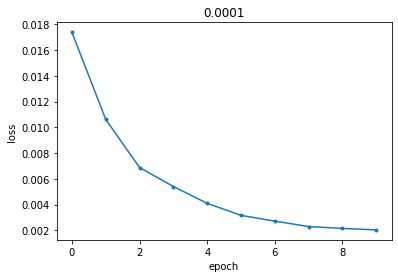

Epoch 1/10
100/100 [==============================] - 465s 5s/step - loss: 0.0022 - vxm_dense_transformer_loss: 0.0020 - vxm_dense_flow_loss: 0.2272
Epoch 2/10
100/100 [==============================] - 461s 5s/step - loss: 0.0020 - vxm_dense_transformer_loss: 0.0018 - vxm_dense_flow_loss: 0.2212
Epoch 3/10
100/100 [==============================] - 462s 5s/step - loss: 0.0019 - vxm_dense_transformer_loss: 0.0017 - vxm_dense_flow_loss: 0.2121
Epoch 4/10
100/100 [==============================] - 461s 5s/step - loss: 0.0018 - vxm_dense_transformer_loss: 0.0016 - vxm_dense_flow_loss: 0.2080
Epoch 5/10
100/100 [==============================] - 461s 5s/step - loss: 0.0018 - vxm_dense_transformer_loss: 0.0015 - vxm_dense_flow_loss: 0.2095
Epoch 6/10
100/100 [==============================] - 470s 5s/step - loss: 0.0017 - vxm_dense_transformer_loss: 0.0015 - vxm_dense_flow_loss: 0.2108
Epoch 7/10
100/100 [==============================] - 464s 5s/step - loss: 0.0016 - vxm_dense_transformer_

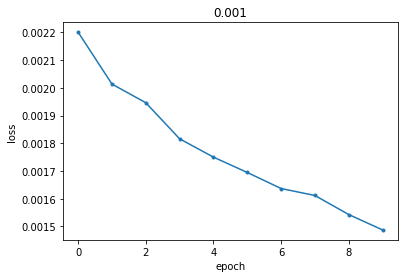

Epoch 1/10
100/100 [==============================] - 466s 5s/step - loss: 0.0028 - vxm_dense_transformer_loss: 0.0016 - vxm_dense_flow_loss: 0.1124
Epoch 2/10
100/100 [==============================] - 461s 5s/step - loss: 0.0025 - vxm_dense_transformer_loss: 0.0016 - vxm_dense_flow_loss: 0.0848
Epoch 3/10
100/100 [==============================] - 461s 5s/step - loss: 0.0024 - vxm_dense_transformer_loss: 0.0016 - vxm_dense_flow_loss: 0.0769
Epoch 4/10
100/100 [==============================] - 461s 5s/step - loss: 0.0023 - vxm_dense_transformer_loss: 0.0015 - vxm_dense_flow_loss: 0.0731
Epoch 5/10
100/100 [==============================] - 461s 5s/step - loss: 0.0022 - vxm_dense_transformer_loss: 0.0015 - vxm_dense_flow_loss: 0.0706
Epoch 6/10
100/100 [==============================] - 461s 5s/step - loss: 0.0022 - vxm_dense_transformer_loss: 0.0015 - vxm_dense_flow_loss: 0.0686
Epoch 7/10
100/100 [==============================] - 460s 5s/step - loss: 0.0021 - vxm_dense_transformer_

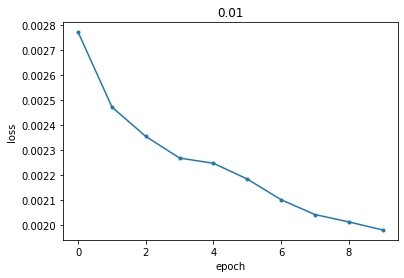

Epoch 1/10
100/100 [==============================] - 465s 5s/step - loss: 0.0055 - vxm_dense_transformer_loss: 0.0026 - vxm_dense_flow_loss: 0.0290
Epoch 2/10
100/100 [==============================] - 461s 5s/step - loss: 0.0048 - vxm_dense_transformer_loss: 0.0025 - vxm_dense_flow_loss: 0.0228
Epoch 3/10
100/100 [==============================] - 461s 5s/step - loss: 0.0047 - vxm_dense_transformer_loss: 0.0025 - vxm_dense_flow_loss: 0.0219
Epoch 4/10
100/100 [==============================] - 460s 5s/step - loss: 0.0045 - vxm_dense_transformer_loss: 0.0024 - vxm_dense_flow_loss: 0.0208
Epoch 5/10
100/100 [==============================] - 459s 5s/step - loss: 0.0044 - vxm_dense_transformer_loss: 0.0024 - vxm_dense_flow_loss: 0.0202
Epoch 6/10
100/100 [==============================] - 459s 5s/step - loss: 0.0042 - vxm_dense_transformer_loss: 0.0023 - vxm_dense_flow_loss: 0.0191
Epoch 7/10
100/100 [==============================] - 459s 5s/step - loss: 0.0040 - vxm_dense_transformer_

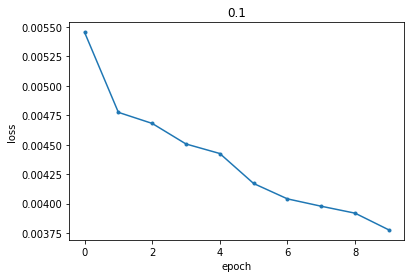

Epoch 1/10
100/100 [==============================] - 465s 5s/step - loss: 0.0132 - vxm_dense_transformer_loss: 0.0070 - vxm_dense_flow_loss: 0.0061
Epoch 2/10
100/100 [==============================] - 460s 5s/step - loss: 0.0114 - vxm_dense_transformer_loss: 0.0076 - vxm_dense_flow_loss: 0.0038
Epoch 3/10
100/100 [==============================] - 461s 5s/step - loss: 0.0103 - vxm_dense_transformer_loss: 0.0070 - vxm_dense_flow_loss: 0.0033
Epoch 4/10
100/100 [==============================] - 461s 5s/step - loss: 0.0098 - vxm_dense_transformer_loss: 0.0065 - vxm_dense_flow_loss: 0.0033
Epoch 5/10
100/100 [==============================] - 460s 5s/step - loss: 0.0094 - vxm_dense_transformer_loss: 0.0061 - vxm_dense_flow_loss: 0.0033
Epoch 6/10
100/100 [==============================] - 461s 5s/step - loss: 0.0091 - vxm_dense_transformer_loss: 0.0058 - vxm_dense_flow_loss: 0.0033
Epoch 7/10
100/100 [==============================] - 461s 5s/step - loss: 0.0088 - vxm_dense_transformer_

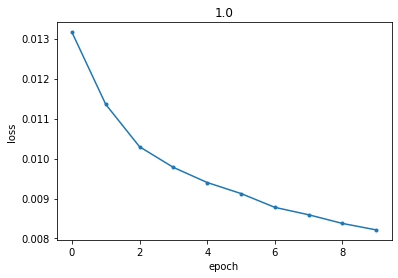

In [30]:
# UNET architecture

vol_shape = slices_train[0].shape
nb_features = [
    [16, 32, 32, 32],             # encoder
    [32, 32, 32, 32, 32, 16, 16]  # decoder
]

# build vxm network using VxmDense
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0);

# Losses : MSE + smoothness (regularization) 
losses = ['mse', vxm.losses.Grad('l2').loss]

# Regularizer
lambdas = np.logspace(-4,0,5)
for lambda_ in lambdas :

    loss_weights = [1, lambda_]
    
#     vxm_model = tf.keras.utils.multi_gpu_model(vxm_model, gpus=2)
    # Adam optimizer learning rate
    vxm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)
    
    # Training
    train_generator = util.vxm_data_generator(slices_train, 12, batch_size = 20)
    hist = vxm_model.fit(train_generator, epochs=10, steps_per_epoch= 100, verbose=1);
    # Visualize the losses
    util.plot_history(hist, save_name = str(lambda_))
    title = "weights" + str(lambda_) + ".keras"
    # If it looks ok => save the weights
    vxm_model.save_weights(title)

In [27]:
# Load the best weights found
title = "weights" + str(lambdas[-2]) + ".keras"
vxm_model.load_weights(title)

# Validation set generator
val_generator = util.vxm_data_generator(slices_test, 12, batch_size = 15)
val_input, _ = next(val_generator)
our_val_pred = vxm_model.predict(val_input);

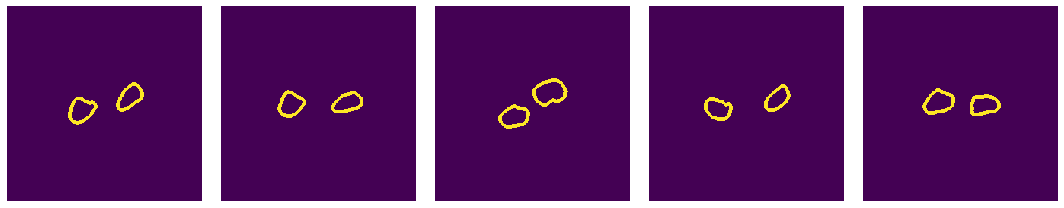

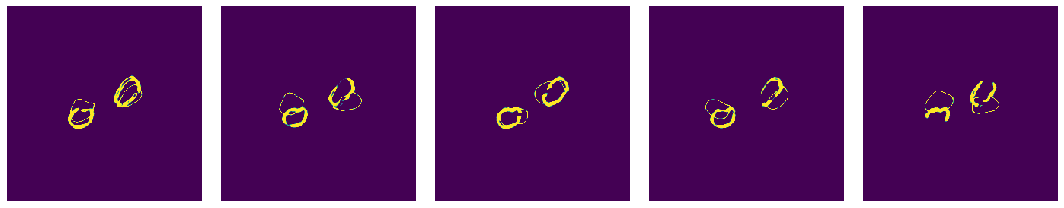

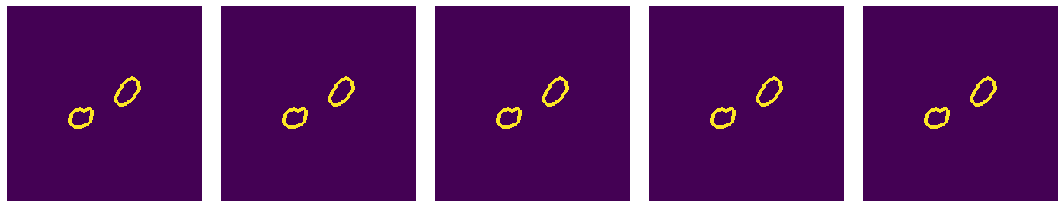

In [28]:
moving = np.squeeze(val_input[0])
fixed = np.squeeze(val_input[1])
moved = np.squeeze(our_val_pred[0])

a = [moved[i, ...] for i in range(5)]
b = [moving[i, ...] for i in range(5)]
c = [fixed[i, ...] for i in range(5)]


# Moving
ne.plot.slices(b, do_colorbars=True);
# Moved
ne.plot.slices(a, do_colorbars=True);
# Fixed
ne.plot.slices(c, do_colorbars=True);

Epoch 1/10
100/100 [==============================] - 466s 5s/step - loss: 443.3542 - vxm_dense_transformer_loss: 443.3542 - vxm_dense_flow_loss: 0.0169
Epoch 2/10
100/100 [==============================] - 463s 5s/step - loss: 182.6248 - vxm_dense_transformer_loss: 182.6248 - vxm_dense_flow_loss: 0.1923
Epoch 3/10
100/100 [==============================] - 463s 5s/step - loss: 153.1234 - vxm_dense_transformer_loss: 153.1233 - vxm_dense_flow_loss: 0.2329
Epoch 4/10
100/100 [==============================] - 462s 5s/step - loss: 145.9464 - vxm_dense_transformer_loss: 145.9464 - vxm_dense_flow_loss: 0.2142
Epoch 5/10
100/100 [==============================] - 464s 5s/step - loss: 139.6695 - vxm_dense_transformer_loss: 139.6694 - vxm_dense_flow_loss: 0.1934
Epoch 6/10
100/100 [==============================] - 463s 5s/step - loss: 135.3494 - vxm_dense_transformer_loss: 135.3494 - vxm_dense_flow_loss: 0.1833
Epoch 7/10
100/100 [==============================] - 464s 5s/step - loss: 131.394

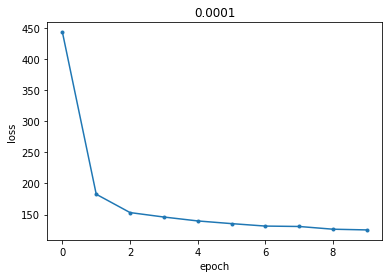

Epoch 1/10
100/100 [==============================] - 469s 5s/step - loss: 137.2762 - vxm_dense_transformer_loss: 137.2760 - vxm_dense_flow_loss: 0.1839
Epoch 2/10
100/100 [==============================] - 463s 5s/step - loss: 122.1315 - vxm_dense_transformer_loss: 122.1313 - vxm_dense_flow_loss: 0.1890
Epoch 3/10
100/100 [==============================] - 463s 5s/step - loss: 122.2427 - vxm_dense_transformer_loss: 122.2425 - vxm_dense_flow_loss: 0.1916
Epoch 4/10
100/100 [==============================] - 464s 5s/step - loss: 120.2858 - vxm_dense_transformer_loss: 120.2856 - vxm_dense_flow_loss: 0.2012
Epoch 5/10
100/100 [==============================] - 463s 5s/step - loss: 119.2022 - vxm_dense_transformer_loss: 119.2019 - vxm_dense_flow_loss: 0.2147
Epoch 6/10
100/100 [==============================] - 463s 5s/step - loss: 118.8924 - vxm_dense_transformer_loss: 118.8922 - vxm_dense_flow_loss: 0.2273
Epoch 7/10
100/100 [==============================] - 463s 5s/step - loss: 117.942

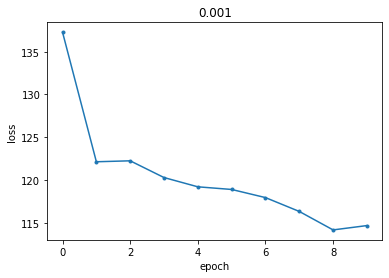

Epoch 1/10
100/100 [==============================] - 470s 5s/step - loss: 122.8070 - vxm_dense_transformer_loss: 122.8046 - vxm_dense_flow_loss: 0.2428
Epoch 2/10
100/100 [==============================] - 464s 5s/step - loss: 113.5768 - vxm_dense_transformer_loss: 113.5740 - vxm_dense_flow_loss: 0.2736
Epoch 3/10
100/100 [==============================] - 464s 5s/step - loss: 111.9743 - vxm_dense_transformer_loss: 111.9715 - vxm_dense_flow_loss: 0.2786
Epoch 4/10
100/100 [==============================] - 464s 5s/step - loss: 112.4527 - vxm_dense_transformer_loss: 112.4499 - vxm_dense_flow_loss: 0.2846
Epoch 5/10
100/100 [==============================] - 465s 5s/step - loss: 110.6730 - vxm_dense_transformer_loss: 110.6701 - vxm_dense_flow_loss: 0.2916
Epoch 6/10
100/100 [==============================] - 463s 5s/step - loss: 109.5584 - vxm_dense_transformer_loss: 109.5554 - vxm_dense_flow_loss: 0.2999
Epoch 7/10
100/100 [==============================] - 463s 5s/step - loss: 109.294

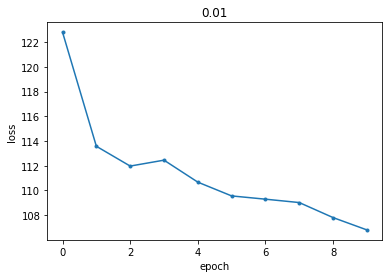

Epoch 1/10
100/100 [==============================] - 469s 5s/step - loss: 115.6810 - vxm_dense_transformer_loss: 115.6485 - vxm_dense_flow_loss: 0.3253
Epoch 2/10
100/100 [==============================] - 463s 5s/step - loss: 105.9283 - vxm_dense_transformer_loss: 105.8954 - vxm_dense_flow_loss: 0.3286
Epoch 3/10
100/100 [==============================] - 464s 5s/step - loss: 105.5275 - vxm_dense_transformer_loss: 105.4941 - vxm_dense_flow_loss: 0.3350
Epoch 4/10
100/100 [==============================] - 464s 5s/step - loss: 104.8779 - vxm_dense_transformer_loss: 104.8445 - vxm_dense_flow_loss: 0.3339
Epoch 5/10
100/100 [==============================] - 464s 5s/step - loss: 104.7913 - vxm_dense_transformer_loss: 104.7575 - vxm_dense_flow_loss: 0.3379
Epoch 6/10
100/100 [==============================] - 463s 5s/step - loss: 104.1574 - vxm_dense_transformer_loss: 104.1235 - vxm_dense_flow_loss: 0.3389
Epoch 7/10
100/100 [==============================] - 465s 5s/step - loss: 103.600

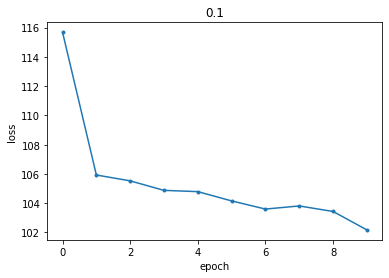

Epoch 1/10
100/100 [==============================] - 513s 5s/step - loss: 110.8377 - vxm_dense_transformer_loss: 110.4925 - vxm_dense_flow_loss: 0.3451
Epoch 2/10
100/100 [==============================] - 498s 5s/step - loss: 101.8509 - vxm_dense_transformer_loss: 101.5050 - vxm_dense_flow_loss: 0.3459
Epoch 3/10
100/100 [==============================] - 504s 5s/step - loss: 101.9525 - vxm_dense_transformer_loss: 101.6063 - vxm_dense_flow_loss: 0.3462
Epoch 4/10
100/100 [==============================] - 511s 5s/step - loss: 101.3154 - vxm_dense_transformer_loss: 100.9682 - vxm_dense_flow_loss: 0.3471
Epoch 5/10
100/100 [==============================] - 553s 6s/step - loss: 100.8789 - vxm_dense_transformer_loss: 100.5315 - vxm_dense_flow_loss: 0.3474
Epoch 6/10
100/100 [==============================] - 575s 6s/step - loss: 100.3720 - vxm_dense_transformer_loss: 100.0261 - vxm_dense_flow_loss: 0.3458
Epoch 7/10
100/100 [==============================] - 593s 6s/step - loss: 100.070

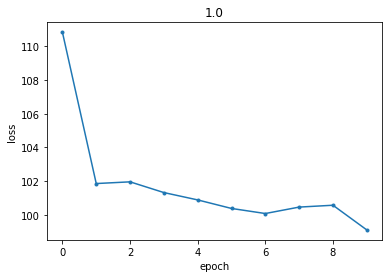

In [31]:
slices_train = np.array([util.crop_ctr_mass(r_MIP[i],128) for i in keys_train])
slices_test  = np.array([util.crop_ctr_mass(r_MIP[i],128) for i in keys_test])

vol_shape = slices_train[0].shape
nb_features = [
    [16, 32, 32, 32],             # encoder
    [32, 32, 32, 32, 32, 16, 16]  # decoder
]

# build vxm network using VxmDense
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0);

# Losses : MSE + smoothness (regularization) 
losses = ['mse', vxm.losses.Grad('l2').loss]

# Regularizer
lambdas = np.logspace(-4,0,5)
for lambda_ in lambdas :

    loss_weights = [1, lambda_]
    
    # vxm_model = tf.keras.utils.multi_gpu_model(vxm_model, gpus=2)
    # Adam optimizer learning rate
    vxm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)
    
    # Training
    train_generator = util.vxm_data_generator(slices_train, 12, batch_size = 20)
    hist = vxm_model.fit(train_generator, epochs=10, steps_per_epoch= 100, verbose=1);
    # Visualize the losses
    util.plot_history(hist, save_name = str(lambda_))
    title = "weights_rchan" + str(lambda_) + ".keras"
    # If it looks ok => save the weights
    vxm_model.save_weights(title)

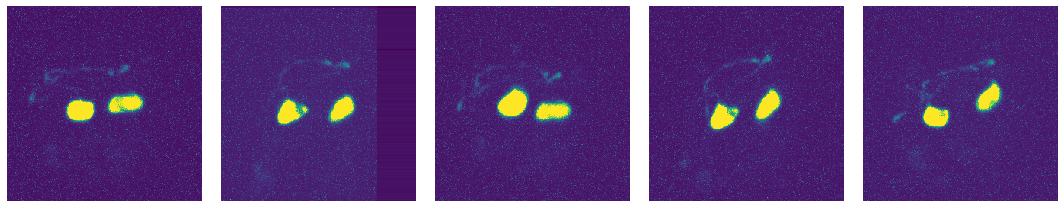

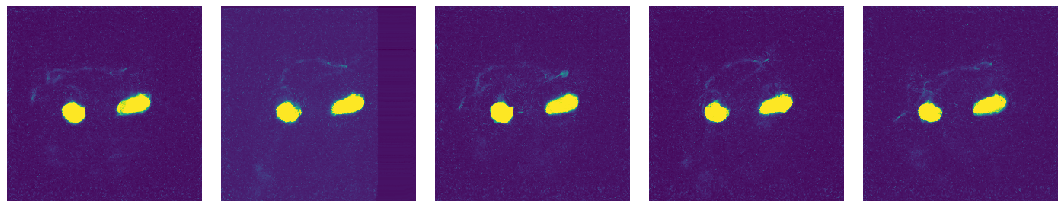

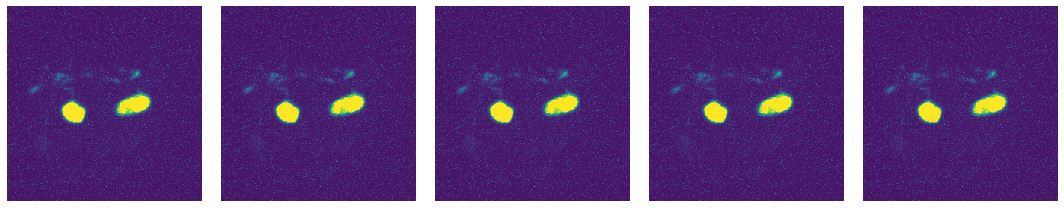

In [42]:
# Load the best weights found
title = "weights_rchan" + str(lambdas[-1]) + ".keras"
vxm_model.load_weights(title)

# Validation set generator
val_generator = util.vxm_data_generator(slices_test, 52, batch_size = 15)
val_input, _ = next(val_generator)
our_val_pred = vxm_model.predict(val_input);

moving = np.squeeze(val_input[0])
fixed = np.squeeze(val_input[1])
moved = np.squeeze(our_val_pred[0])

a = [moved[i, ...] for i in range(5)]
b = [moving[i, ...] for i in range(5)]
c = [fixed[i, ...] for i in range(5)]


# Moving
ne.plot.slices(b, do_colorbars=True);
# Moved
ne.plot.slices(a, do_colorbars=True);
# Fixed
ne.plot.slices(c, do_colorbars=True);